In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
import os
import struct
import json
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#DATA PATHS

In [3]:
filePredicTimesGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_gunshot_times.json"
filePredicTimesSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_siren_times.json"
filePredicTimesScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_scream_times.json"

ALLDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_gunshot.csv"
ALLDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_siren.csv"
ALLDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_scream.csv"


AVGDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot.csv"
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren.csv"
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream.csv"


BestDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"
BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"
BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"


AVGDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
AVGDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren_flops.csv"
AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"


BestDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"
BestDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"
BestDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"

paretoDataOutPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/pareto_points_out_gunshot.xlsx"
paretoDataOutPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/pareto_points_out_siren.xlsx"
paretoDataOutPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/pareto_points_out_scream.xlsx"

AVGDataOutputPathThreeEvents = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_3_events_flops.csv"
paretoAVGDataOutPathEvents = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/pareto_points_out_avg.xlsx"

#SUMMARY EXPERIMENTS ANALYSIS

In [4]:

import datetime
import pandas as pd     # Import pandas library
import seaborn as sb

dfExperimentsGun = pd.read_csv(AVGDataOutputPathGunshotFLOPS, index_col=0)
dfExperimentsGun
dfExperimentsGun.sort_values(by='F1Score', ascending=False)

,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
1866,1867,24,4096,512,384,0.25,5,0 days 00:00:00.017560,0 days 00:09:20.393406,98.2,98.2,80,57776902.0,0 days 00:00:00.092999,0 days 00:00:00.295936,0 days 00:00:00.011692
2155,2156,27,4096,4096,3072,0.25,7,0 days 00:00:00.013589,0 days 00:00:45.816381,98.2,98.2,70,17950926.0,0 days 00:00:00.056849,0 days 00:00:00.275834,0 days 00:00:00.003850
3353,3354,42,4096,4096,3072,0.25,3,0 days 00:00:00.013353,0 days 00:01:02.756126,98.0,98.0,79,5058502.0,0 days 00:00:00.059994,0 days 00:00:00.285096,0 days 00:00:00.001197
3595,3596,45,4096,4096,3072,0.25,7,0 days 00:00:00.009621,0 days 00:00:53.673228,98.0,98.0,70,28989070.0,0 days 00:00:00.058892,0 days 00:00:00.291579,0 days 00:00:00.005847
1181,1182,15,4096,2048,2048,0.00,3,0 days 00:00:00.014262,0 days 00:00:50.048719,98.0,98.0,78,2736910.0,0 days 00:00:00.060397,0 days 00:00:00.277748,0 days 00:00:00.000701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,3,3,256,256,64,0.75,5,0 days 00:00:00.012349,0 days 00:00:15.236896,66.4,76.4,31,76050198.0,0 days 00:00:00.055783,0 days 00:00:00.281692,0 days 00:00:00.014182
1685,1686,24,256,256,128,0.50,3,0 days 00:00:00.008463,0 days 00:00:20.639784,66.2,73.4,34,63194438.0,0 days 00:00:00.048179,0 days 00:00:00.296603,0 days 00:00:00.013916
736,737,12,512,256,64,0.75,2,0 days 00:00:00.013077,0 days 00:00:22.980014,63.2,78.2,46,31303462.0,0 days 00:00:00.077169,0 days 00:00:00.285545,0 days 00:00:00.008085
48,49,3,1024,256,64,0.75,2,0 days 00:00:00.016197,0 days 00:00:17.299144,61.8,68.6,36,12338550.0,0 days 00:00:00.090533,0 days 00:00:00.269906,0 days 00:00:00.002722


In [ ]:

dfExperimentsSiren = pd.read_csv(AVGDataOutputPathSirenFLOPS, index_col=0)
dfExperimentsSiren
dfExperimentsSiren.sort_values(by='F1Score', ascending=False)



,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
2379,2380,30,4096,2048,1536,0.25,7,0 days 00:00:00.012389,0 days 00:01:28.267421,96.6,96.8,79,38848966.0,0 days 00:00:00.069230,0 days 00:00:00.288553,0 days 00:00:00.008074
3583,3584,45,4096,2048,2048,0.00,7,0 days 00:00:00.016204,0 days 00:01:15.589898,96.6,96.8,72,43861638.0,0 days 00:00:00.069074,0 days 00:00:00.297024,0 days 00:00:00.008835
1918,1919,24,4096,4096,4096,0.00,5,0 days 00:00:00.016446,0 days 00:00:52.452882,96.4,96.4,69,5604486.0,0 days 00:00:00.068739,0 days 00:00:00.285148,0 days 00:00:00.001372
1910,1911,24,4096,4096,2048,0.50,5,0 days 00:00:00.014368,0 days 00:01:06.469037,96.4,96.8,72,11381830.0,0 days 00:00:00.070045,0 days 00:00:00.288913,0 days 00:00:00.002469
3342,3343,42,4096,2048,2048,0.00,5,0 days 00:00:00.013437,0 days 00:01:16.139716,96.4,96.6,72,21147766.0,0 days 00:00:00.078060,0 days 00:00:00.299374,0 days 00:00:00.004405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,38,3,512,512,256,0.50,3,0 days 00:00:00.010089,0 days 00:00:35.702681,31.4,59.2,40,6993734.0,0 days 00:00:00.058379,0 days 00:00:00.278605,0 days 00:00:00.001517
101,102,3,2048,256,128,0.50,3,0 days 00:00:00.033143,0 days 00:00:41.858845,30.8,60.0,39,14089742.0,0 days 00:00:00.112788,0 days 00:00:00.280622,0 days 00:00:00.002976
53,54,3,1024,256,128,0.50,3,0 days 00:00:00.024313,0 days 00:00:36.145380,28.8,58.4,32,14089742.0,0 days 00:00:00.078234,0 days 00:00:00.272632,0 days 00:00:00.002954
41,42,3,512,512,384,0.25,3,0 days 00:00:00.012053,0 days 00:00:33.596816,21.4,57.0,43,4702734.0,0 days 00:00:00.058715,0 days 00:00:00.271901,0 days 00:00:00.001098


In [ ]:

dfExperimentsScream = pd.read_csv(AVGDataOutputPathScreamFLOPS, index_col=0)
dfExperimentsScream
dfExperimentsScream.sort_values(by='F1Score', ascending=False)

,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
3514,3515,45,2048,2048,1536,0.25,5,0 days 00:00:00.007478,0 days 00:01:15.503693,99.0,99.0,78,29025358.0,0 days 00:00:00.049028,0 days 00:00:00.284737,0 days 00:00:00.005912
3273,3274,42,2048,2048,1536,0.25,3,0 days 00:00:00.007804,0 days 00:01:18.874804,99.0,99.0,80,9919318.0,0 days 00:00:00.041542,0 days 00:00:00.291989,0 days 00:00:00.002269
874,875,12,2048,2048,1536,0.25,5,0 days 00:00:00.009676,0 days 00:00:58.067808,98.8,98.8,76,8191238.0,0 days 00:00:00.040695,0 days 00:00:00.286770,0 days 00:00:00.001860
3030,3031,39,2048,2048,1024,0.50,5,0 days 00:00:00.010617,0 days 00:01:26.982566,98.8,98.8,80,37098902.0,0 days 00:00:00.051691,0 days 00:00:00.298306,0 days 00:00:00.007614
3337,3338,42,4096,2048,1536,0.25,3,0 days 00:00:00.011635,0 days 00:01:13.141131,98.8,98.8,80,9919318.0,0 days 00:00:00.055470,0 days 00:00:00.294059,0 days 00:00:00.002311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,101,3,2048,256,128,0.50,2,0 days 00:00:00.029438,0 days 00:00:08.599007,67.2,67.4,15,6188142.0,0 days 00:00:00.107905,0 days 00:00:00.280761,0 days 00:00:00.001469
160,161,3,4096,256,64,0.75,2,0 days 00:00:00.079544,0 days 00:00:15.775672,66.4,76.4,19,12338550.0,0 days 00:00:00.318210,0 days 00:00:00.280257,0 days 00:00:00.002810
720,721,12,256,256,64,0.75,2,0 days 00:00:00.014033,0 days 00:01:03.135909,66.0,71.4,39,31303462.0,0 days 00:00:00.053497,0 days 00:00:00.302682,0 days 00:00:00.007688
240,241,6,256,256,64,0.75,2,0 days 00:00:00.014138,0 days 00:00:49.491385,64.2,72.4,43,17166550.0,0 days 00:00:00.059352,0 days 00:00:00.289400,0 days 00:00:00.004363


In [5]:
dfExperimentsAVGEvents= pd.read_csv(AVGDataOutputPathThreeEvents, index_col=0)
dfExperimentsAVGEvents
dfExperimentsAVGEvents.sort_values(by='F1Score', ascending=False)

,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
3594,3595,45,4096,4096,3072,0.25,5,0 days 00:00:00.009621,0 days 00:00:48.882579,97.400000,97.600000,73.666667,1.481753e+07,0 days 00:00:00.058396,0 days 00:00:00.284777,0 days 00:00:00.003099
3598,3599,45,4096,4096,4096,0.00,5,0 days 00:00:00.013003,0 days 00:00:57.901053,97.266667,97.333333,77.666667,1.103981e+07,0 days 00:00:00.057826,0 days 00:00:00.303188,0 days 00:00:00.002368
3595,3596,45,4096,4096,3072,0.25,7,0 days 00:00:00.009621,0 days 00:00:53.673228,97.266667,97.466667,73.000000,2.900095e+07,0 days 00:00:00.058892,0 days 00:00:00.291579,0 days 00:00:00.005847
3354,3355,42,4096,4096,3072,0.25,5,0 days 00:00:00.013353,0 days 00:00:50.428941,97.133333,97.400000,75.666667,1.398581e+07,0 days 00:00:00.051221,0 days 00:00:00.293243,0 days 00:00:00.002919
3115,3116,39,4096,4096,3072,0.25,7,0 days 00:00:00.012603,0 days 00:00:50.480505,97.000000,97.133333,73.666667,2.451687e+07,0 days 00:00:00.056211,0 days 00:00:00.290164,0 days 00:00:00.005263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,101,3,2048,256,128,0.50,2,0 days 00:00:00.018816,0 days 00:00:30.555801,65.066667,71.600000,36.666667,6.232062e+06,0 days 00:00:00.104862,0 days 00:00:00.275531,0 days 00:00:00.001439
56,57,3,1024,256,192,0.25,2,0 days 00:00:00.010366,0 days 00:00:15.963638,65.000000,72.666667,31.333333,4.161977e+06,0 days 00:00:00.069844,0 days 00:00:00.272452,0 days 00:00:00.001007
52,53,3,1024,256,128,0.50,2,0 days 00:00:00.012263,0 days 00:00:17.265139,62.866667,67.600000,24.666667,6.232062e+06,0 days 00:00:00.070124,0 days 00:00:00.277282,0 days 00:00:00.001458
48,49,3,1024,256,64,0.75,2,0 days 00:00:00.016197,0 days 00:00:17.299144,62.400000,66.533333,27.666667,1.242363e+07,0 days 00:00:00.090533,0 days 00:00:00.269906,0 days 00:00:00.002722


#PARETO POINTS ANALYSIS

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


def showParetoFront(AVGDataOutputPathFLOPS):
  # Cargar datos desde archivo CSV
  dfFlops = pd.read_csv(AVGDataOutputPathFLOPS)
  # Convertir métrica que se desea minimizar a su valor absoluto
  dfFlops['FLOPS'] = dfFlops['FLOPS'].abs()

  # Ordenar puntos por la variable que se desea minimizar
  dfSorted = dfFlops.sort_values(by='FLOPS')

  # Encontrar puntos de Pareto óptimos
  pareto_front = []
  max_f1score = -float('inf')
  for i, row in dfSorted.iterrows():
      if row['F1Score'] > max_f1score:
          pareto_front.append(i)
          max_f1score = row['F1Score']

  # Imprimir índices de puntos de Pareto óptimos
  print('Los índices de los puntos de Pareto óptimos son:')
  print(pareto_front)

  # Graficar datos y puntos de Pareto óptimos
  plt.scatter(dfFlops['FLOPS'], 100-dfFlops['F1Score'])
  plt.scatter(dfFlops.iloc[pareto_front]['FLOPS'], 100-dfFlops.iloc[pareto_front]['F1Score'], color='r')
  plt.xlabel('FLOPS')
  plt.ylabel('100 - F1Score')
  plt.show()

  return dfFlops, pareto_front


#SAVE PARETO POINTS ANALYSIS

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import re

def saveParetoPointsOut(paretoDataframe,paretoDataOutPath):
    # Read the CSV file
    data = paretoDataframe[["NMFCC", "Nfft", "NwinL", "NhopL",	"Overlap",	"Ksize",	"F1Score", "FLOPS", "AVGVimPredictTime", "AVGVimTFLitePredictTime"]]

    # Define the lambda function
    convert_to_milliseconds = lambda x: int(re.search(r"(\d+) days (\d+):(\d+):(\d+).(\d+)", x).group(1)) * 24 * 60 * 60 * 1000 \
                                      + int(re.search(r"(\d+) days (\d+):(\d+):(\d+).(\d+)", x).group(2)) * 60 * 60 * 1000 \
                                      + int(re.search(r"(\d+) days (\d+):(\d+):(\d+).(\d+)", x).group(3)) * 60 * 1000 \
                                      + int(re.search(r"(\d+) days (\d+):(\d+):(\d+).(\d+)", x).group(4)) * 1000 \
                                      + int(re.search(r"(\d+) days (\d+):(\d+):(\d+).(\d+)", x).group(5)) / 1000

    # Apply the lambda function to the DataFrame column
    data['AVGVimPredictTime'] = data['AVGVimPredictTime'].apply(convert_to_milliseconds)
    # Apply the lambda function to the DataFrame column
    data['AVGVimTFLitePredictTime'] = data['AVGVimTFLitePredictTime'].apply(convert_to_milliseconds)

    print(data)
    data.to_excel(paretoDataOutPath)
    print("FILE SAVED CORRECT WAY")
    print(data.shape)

Los índices de los puntos de Pareto óptimos son:
[236, 232, 156, 237, 233, 1437, 1193, 1433, 1181, 2155]


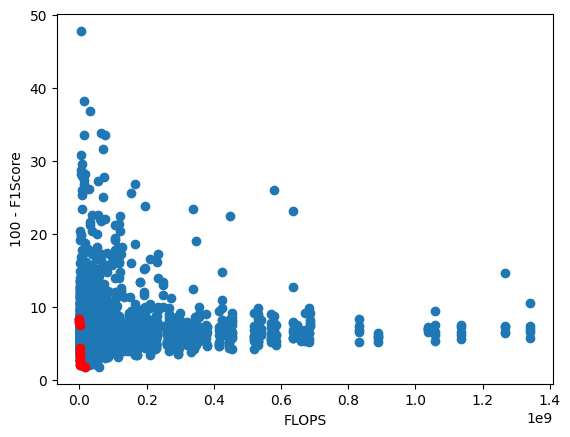

El DataFrame de los puntos de Pareto óptimos es:
      NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize  F1Score       FLOPS  \
236       3  4096   4096   4096     0.00      2     91.6    200374.0   
232       3  4096   4096   3072     0.25      2     92.0    268190.0   
156       3  2048   2048   2048     0.00      2     92.4    404574.0   
237       3  4096   4096   4096     0.00      3     95.6    446294.0   
233       3  4096   4096   3072     0.25      3     96.2    597710.0   
1437     18  4096   4096   4096     0.00      3     96.8   1743798.0   
1193     15  4096   4096   3072     0.25      3     97.2   1809998.0   
1433     18  4096   4096   3072     0.25      3     97.4   2337606.0   
1181     15  4096   2048   2048     0.00      3     98.0   2736910.0   
2155     27  4096   4096   3072     0.25      7     98.2  17950926.0   

      AVGVimPredictTime  AVGVimTFLitePredictTime  
236             283.825                    0.156  
232             273.555                    0.173  
156  

<ipython-input-7-93de74900c20>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimPredictTime'] = data['AVGVimPredictTime'].apply(convert_to_milliseconds)
<ipython-input-7-93de74900c20>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimTFLitePredictTime'] = data['AVGVimTFLitePredictTime'].apply(convert_to_milliseconds)


FILE SAVED CORRECT WAY
(10, 10)


In [ ]:

dfGunshotFlops, pareto_frontGun = showParetoFront(AVGDataOutputPathGunshotFLOPS)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfGunshotFlops.iloc[pareto_frontGun, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

saveParetoPointsOut(pareto_df, paretoDataOutPathGunshot)

Los índices de los puntos de Pareto óptimos son:
[236, 232, 476, 472, 956, 712, 952, 473, 461, 2876, 953, 478, 3592, 2873, 874, 3273]


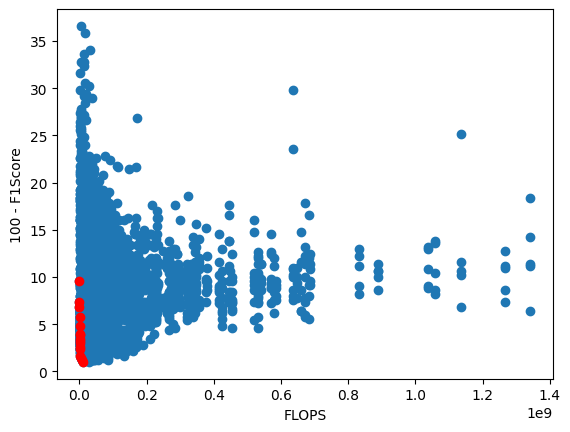

El DataFrame de los puntos de Pareto óptimos es:
      NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize  F1Score      FLOPS  \
236       3  4096   4096   4096     0.00      2     90.4   200374.0   
232       3  4096   4096   3072     0.25      2     92.6   268190.0   
476       6  4096   4096   4096     0.00      2     93.2   277910.0   
472       6  4096   4096   3072     0.25      2     94.2   372198.0   
956      12  4096   4096   4096     0.00      2     95.2   505190.0   
712       9  4096   4096   3072     0.25      2     96.0   639486.0   
952      12  4096   4096   3072     0.25      2     96.2   677190.0   
473       6  4096   4096   3072     0.25      3     96.6   828998.0   
461       6  4096   2048   2048     0.00      3     96.8  1251718.0   
2876     36  4096   4096   4096     0.00      2     97.0  1416166.0   
953      12  4096   4096   3072     0.25      3     97.4  1508870.0   
478       6  4096   4096   4096     0.00      5     97.6  1709270.0   
3592     45  4096   4096   3

<ipython-input-7-93de74900c20>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimPredictTime'] = data['AVGVimPredictTime'].apply(convert_to_milliseconds)
<ipython-input-7-93de74900c20>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimTFLitePredictTime'] = data['AVGVimTFLitePredictTime'].apply(convert_to_milliseconds)


FILE SAVED CORRECT WAY
(16, 10)


In [ ]:
dfScreamFlops, pareto_frontScream = showParetoFront(AVGDataOutputPathScreamFLOPS)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfScreamFlops.iloc[pareto_frontScream, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

saveParetoPointsOut(pareto_df, paretoDataOutPathScream)

Los índices de los puntos de Pareto óptimos son:
[236, 232, 476, 716, 956, 1196, 1436, 1676, 957, 1437, 1677, 2157, 1673, 2397, 1438, 1678, 1918, 2379]


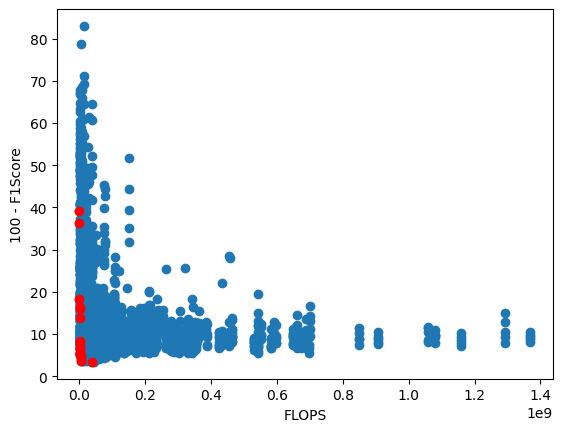

El DataFrame de los puntos de Pareto óptimos es:
      NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize  F1Score       FLOPS  \
236       3  4096   4096   4096     0.00      2     60.8    200374.0   
232       3  4096   4096   3072     0.25      2     63.8    268406.0   
476       6  4096   4096   4096     0.00      2     81.8    277910.0   
716       9  4096   4096   4096     0.00      2     83.6    477382.0   
956      12  4096   4096   4096     0.00      2     84.0    505190.0   
1196     15  4096   4096   4096     0.00      2     86.2    605782.0   
1436     18  4096   4096   4096     0.00      2     91.6    782838.0   
1676     21  4096   4096   4096     0.00      2     92.2    883430.0   
957      12  4096   4096   4096     0.00      3     93.2   1125350.0   
1437     18  4096   4096   4096     0.00      3     93.4   1743798.0   
1677     21  4096   4096   4096     0.00      3     94.4   1967430.0   
2157     27  4096   4096   4096     0.00      3     94.6   2474070.0   
1673     21  40

<ipython-input-7-93de74900c20>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimPredictTime'] = data['AVGVimPredictTime'].apply(convert_to_milliseconds)
<ipython-input-7-93de74900c20>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimTFLitePredictTime'] = data['AVGVimTFLitePredictTime'].apply(convert_to_milliseconds)


In [ ]:
dfSirenFlops, pareto_frontSiren= showParetoFront(AVGDataOutputPathSirenFLOPS)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfSirenFlops.iloc[pareto_frontSiren, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

saveParetoPointsOut(pareto_df, paretoDataOutPathSiren)

Los índices de los puntos de Pareto óptimos son:
[236, 232, 476, 716, 956, 1196, 1436, 1676, 957, 953, 1437, 1193, 1917, 2157, 1673, 2397, 2637, 2153, 3357, 3353, 1662, 3598, 3594]


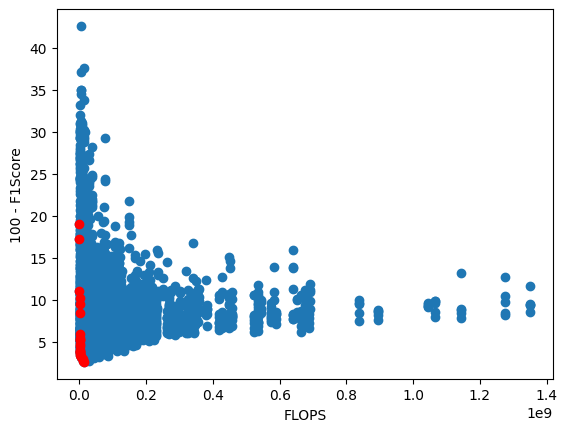

El DataFrame de los puntos de Pareto óptimos es:
      NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize    F1Score       FLOPS  \
236       3  4096   4096   4096     0.00      2  80.933333    200374.0   
232       3  4096   4096   3072     0.25      2  82.800000    268262.0   
476       6  4096   4096   4096     0.00      2  88.933333    277910.0   
716       9  4096   4096   4096     0.00      2  89.733333    477382.0   
956      12  4096   4096   4096     0.00      2  90.466667    505190.0   
1196     15  4096   4096   4096     0.00      2  91.600000    605782.0   
1436     18  4096   4096   4096     0.00      2  94.066667    782838.0   
1676     21  4096   4096   4096     0.00      2  94.533333    883430.0   
957      12  4096   4096   4096     0.00      3  94.733333   1125350.0   
953      12  4096   4096   3072     0.25      3  94.800000   1509478.0   
1437     18  4096   4096   4096     0.00      3  95.266667   1743798.0   
1193     15  4096   4096   3072     0.25      3  95.533333   18

<ipython-input-7-93de74900c20>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimPredictTime'] = data['AVGVimPredictTime'].apply(convert_to_milliseconds)
<ipython-input-7-93de74900c20>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AVGVimTFLitePredictTime'] = data['AVGVimTFLitePredictTime'].apply(convert_to_milliseconds)


FILE SAVED CORRECT WAY
(23, 10)


In [8]:
AVGDataOutputPathThreeEvents = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_3_events_flops.csv"
paretoAVGDataOutPathEvents = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/pareto_points_out_avg.xlsx"

dfAVGEventsFlops, pareto_frontAVG = showParetoFront(AVGDataOutputPathThreeEvents)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfAVGEventsFlops.iloc[pareto_frontAVG, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

saveParetoPointsOut(pareto_df, paretoAVGDataOutPathEvents)

#PARTIAL CORRELATION ANALYSIS

In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=0c5aee3112bce7b9383f73dcdc5903fc18d5a4f2b4d6d8b56a7dff033325fccc
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


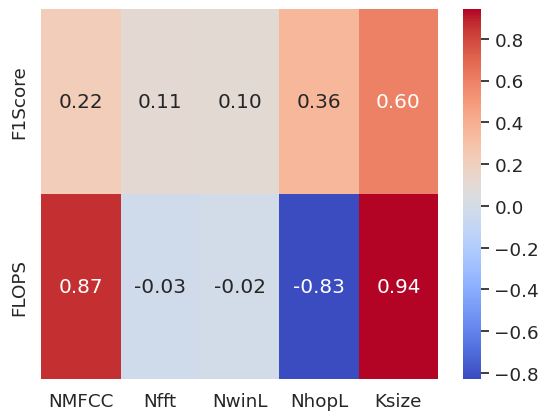

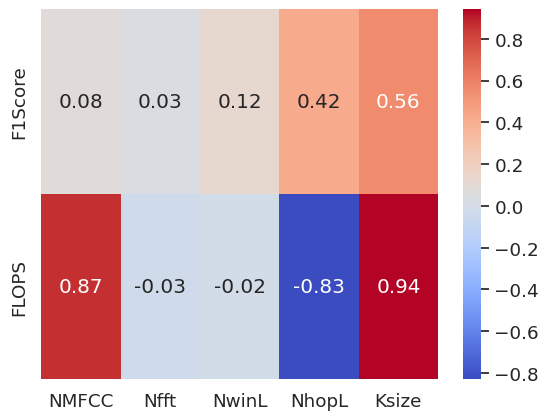

In [ ]:
# only "pearson" and "spearman" are supported for partial correlation.

import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

def partial_corr_matrix(data, method='pearson', interest_col=[]):
    dataNew = pd.DataFrame(data, columns=data.columns.values)
    corr_matrix = dataNew.corr(method=method)
    out_partial_corr_matrix = pd.DataFrame(index=interest_col, columns=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize']).fillna(0.0)
    for value in interest_col:
      columns = list(data.columns.values)
      columns.remove(value)
      dataNew = pd.DataFrame(data, columns=columns)
      corr_matrix = dataNew.corr(method=method)
      temp_partial_corr_matrix = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns).fillna(0.0)
      for col1 in corr_matrix.columns:
          for col2 in corr_matrix.columns:
              if col1 != col2:
                  control_cols = [col for col in corr_matrix.columns if col != col1 and col != col2]
                  partial_corr = pg.partial_corr(data=data, x=col1, y=col2, covar=control_cols, method=method)['r']
                  temp_partial_corr_matrix.loc[col1, col2] = partial_corr[0]
      temp_partial_corr_matrix = temp_partial_corr_matrix.drop(labels=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize'], axis=0)
      interest_col_copy = interest_col.copy()
      interest_col_copy.remove(value)
      temp_partial_corr_matrix = temp_partial_corr_matrix.drop(labels=interest_col_copy, axis=1)
      out_partial_corr_matrix.loc[interest_col_copy] = temp_partial_corr_matrix.loc[interest_col_copy]
    return out_partial_corr_matrix



AVGDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
dfExperimentsGun = pd.read_csv(AVGDataOutputPathGunshotFLOPS, index_col=0)

# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsGunKC = pd.DataFrame(dfExperimentsGun, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsGunKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsGunKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsGunKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Gunshot')
plt.show()


'''# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsSirenKC = pd.DataFrame(dfExperimentsSiren, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsSirenKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]'''

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsSirenKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

'''# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsSirenKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Siren')
plt.show()'''

AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"
dfExperimentsScream = pd.read_csv(AVGDataOutputPathScreamFLOPS, index_col=0)

# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsScreamKC = pd.DataFrame(dfExperimentsScream, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsScreamKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsGunKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsScreamKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Scream ')
plt.show()